In [64]:
import torch
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from types import SimpleNamespace
from models import create_model
from data.base_dataset import get_transform
import torchvision.transforms as T

cycleganmodel
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
loading the model from checkpoints\aus2rus\latest_net_G_A.pth
loading the model from checkpoints\aus2rus\latest_net_G_B.pth
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 54.403 M
[Network G_B] Total number of parameters : 54.403 M
-----------------------------------------------


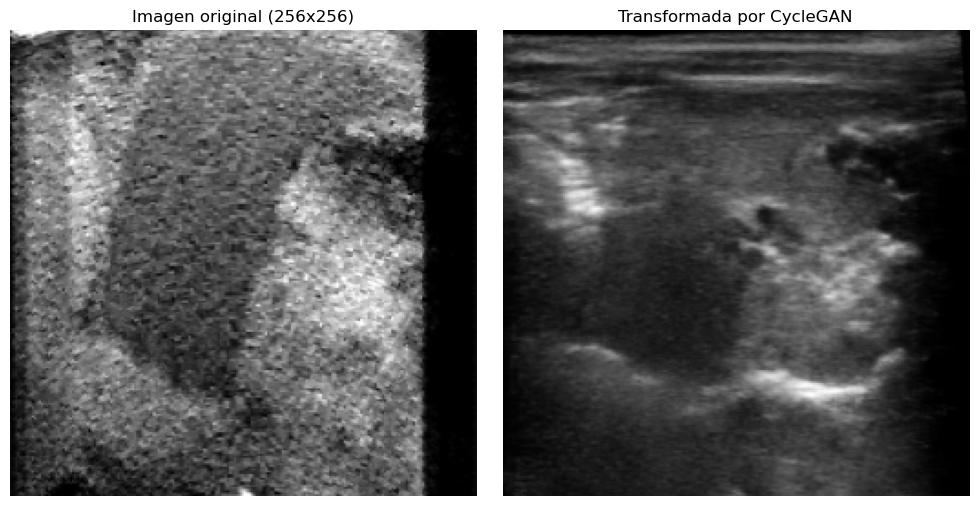

In [73]:
# === 1. Ruta de la imagen a transformar ===
img_path = "resized_ct1-1.png"  # o path completo

# === 2. Definir las opciones exactamente como ultrasound_test.py ===
opt = SimpleNamespace(
    name="aus2rus",
    model='cycle_gan',
    dataset_mode='unaligned',
    netG='unet_256',
    direction='AtoB',
    input_nc=1,
    output_nc=1,
    preprocess='resize_and_crop',
    load_size=256,
    crop_size=256,
    batch_size=1,
    serial_batches=True,
    no_flip=True,
    display_id=-1,
    num_threads=1,
    eval=True,
    load_iter=0,
    epoch='latest',
    aspect_ratio=1.0,
    max_dataset_size=float("inf"),
    gpu_ids=[0] if torch.cuda.is_available() else [],
    isTrain=False,
    checkpoints_dir="checkpoints",
    ngf=64,
    norm='instance',
    no_dropout=True,
    init_type='normal',
    init_gain=0.02,
    verbose=False,
)

# === 3. Cargar el modelo CycleGAN ===
model = create_model(opt)
model.setup(opt)
model.eval()
generator = model.netG_A if opt.direction == 'AtoB' else model.netG_B

# === 4. Cargar imagen, forzar resize a 256x256 como en el test original ===
img = Image.open(img_path).convert('RGB')
img_resized = img.resize((256, 256), Image.BICUBIC)

# === 5. Transformar como ultrasound_test.py (con grayscale=True) ===
transform = get_transform(opt, grayscale=True)
img_tensor = transform(img_resized).unsqueeze(0)  # (1, 1, 256, 256)

if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

# === 6. Obtener predicción
with torch.no_grad():
    fake_tensor = generator(img_tensor)

# === 7. Postprocesar salida
fake_np = fake_tensor.squeeze().cpu().numpy()
fake_np = ((fake_np + 1) / 2.0 * 255.0).clip(0, 255).astype(np.uint8)

# === 8. Mostrar original y transformada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_resized.convert('L'), cmap='gray')
axes[0].set_title("Imagen original (256x256)")
axes[0].axis("off")

axes[1].imshow(fake_np, cmap='gray')
axes[1].set_title("Transformada por CycleGAN")
axes[1].axis("off")

plt.tight_layout()
plt.show()
